In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import reciprocalspaceship as rs
import scipy.optimize as opt
import gemmi as gm
from tqdm import tqdm
import os

import matplotlib
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

In [2]:
from xtal_analysis.xtal_analysis_functions import load_mtz, res_cutoff, scale, compute_weights, scale_iso

In [3]:
from xtal_analysis.params import *

#### Specify all parameters :

In [4]:
path         = '/Users/alisia/Desktop/SACLA_JUN2021/final_scripts/qweighted_maps/apply_qweighting/'

#### (1) Load in calculated_fobs, dark_fobs, light_fobs 

In [5]:
calc  = load_mtz("{path}inputs/FC_dark.mtz".format(path=path))
off   = load_mtz("{path}inputs/neg5ps-400nm_fobs_unique1.mtz".format(path=path))
on    = load_mtz("{path}inputs/{name}_fobs_unique1.mtz".format(path=path, name=name))

##### Optional resolution cut

In [6]:
on    = res_cutoff(on, h_res, l_res)
off   = res_cutoff(off, h_res, l_res)
calc  = res_cutoff(calc, h_res, l_res)

data     = pd.merge(calc, off, how='inner', right_index=True, left_index=True, suffixes=('_calc', '_off'))
data_all = pd.merge(data, on, how='inner', right_index=True, left_index=True, suffixes=('_off', '_on')).dropna()

In [7]:
data_all.head(1)

,,,FC_D,SIG_FC_D,PHI_D,dHKL_calc,FreeR_flag_off,F_off,SIGF_off,dHKL_off,FreeR_flag_on,F_on,SIGF_on,dHKL
H,K,L,,,,,,,,,,,,
0,0,4,72.729,1.0,180.0,18.0075,0,9.283087,0.95805734,18.0075,0,8.011057,0.8635788,18.0075


In [8]:
f_on    = np.array(data_all.F_on)
f_off   = np.array(data_all.F_off)
f_calc  = np.array(data_all.FC_D)

In [9]:
qs = 1/(2*data_all['dHKL'])

results_on, c_on, b_on, on_s     = scale_iso(f_calc, f_on,  np.array(data_all['dHKL']))
results_off, c_off, b_off, off_s = scale_iso(f_calc, f_off, np.array(data_all['dHKL']))

sig_on       = (c_on  * np.exp(-b_on*(qs**2)))  * data_all['SIGF_on']
sig_off      = (c_off * np.exp(-b_off*(qs**2))) * data_all['SIGF_off']

#### (3)  Generate q-weighted structure factors – visualize results for different $\alpha$ factors

In [10]:
diffs = on_s - off_s
sig_diffs = np.sqrt(sig_on**2 + sig_off**2)

ws = compute_weights(diffs, sig_diffs, alpha=alpha)
diffs_w = ws * diffs

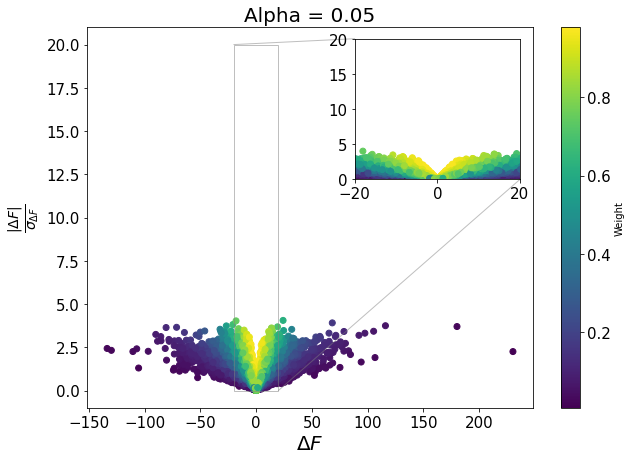

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))
pts = ax.scatter(diffs, np.abs(diffs)/sig_diffs, c=ws)
ax.set_xlabel(r"$\Delta F$", fontsize=20)
ax.set_ylabel(r"$\frac{\left| \Delta F \right|}{\sigma_{\Delta F}}$", fontsize=20)

# Inset
axins = ax.inset_axes([0.6, 0.6, 0.37, 0.37])
axins.scatter(diffs, np.abs(diffs)/sig_diffs, c=ws)
x1, x2, y1, y2 = -20, 20, 0, 20
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins)
ax.set_title('Alpha = {}'.format(alpha), fontsize=20)

fig.colorbar(pts, label="Weight")
plt.show()

#### (4)  Write out map as an mtz

In [12]:
calc["DF"]    = diffs
calc["DF"]    = calc["DF"].astype("SFAmplitude")
calc["WDF"]   = diffs_w
calc["WDF"]   = calc["WDF"].astype("SFAmplitude")
calc["SIGDF"] = sig_diffs
calc["SIGDF"] = calc["SIGDF"].astype("Stddev")

#calc.write_mtz("{path}outputs/{name}_diffmap_{alpha}.mtz".format(path=path, name=name, alpha=alpha))